In [2]:
!pip install pymc3 --user
!pip install theano --user
!pip install statsmodels --user
!pip install Pillow --user
!pip uninstall scipy

     |████████████████████████████████| 2.8MB 4.1MB/s 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import theano

data = pd.read_csv(pm.get_data('radon.csv'))
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())
data[['county', 'log_radon', 'floor']].head()


You can find the C code in this temporary file: /tmp/theano_compilation_error_1sblygxj


Exception: Compilation failed (return status=1): g++: error: '-march=core2': No such file or directory. 

In [2]:
with pm.Model() as unpooled_model:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sd=100, shape=n_counties)
    b = pm.Normal('b', 0, sd=100, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx]*data.floor.values

    # Data likelihood
    y = pm.Normal('y', radon_est, sd=eps, observed=data.log_radon)

In [4]:
with unpooled_model:
    unpooled_trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, b, a]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:21<00:00, 783.23draws/s]


In [6]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [7]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=2000, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 3 chains: 100%|██████████| 7500/7500 [00:13<00:00, 550.38draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7145325980036029, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


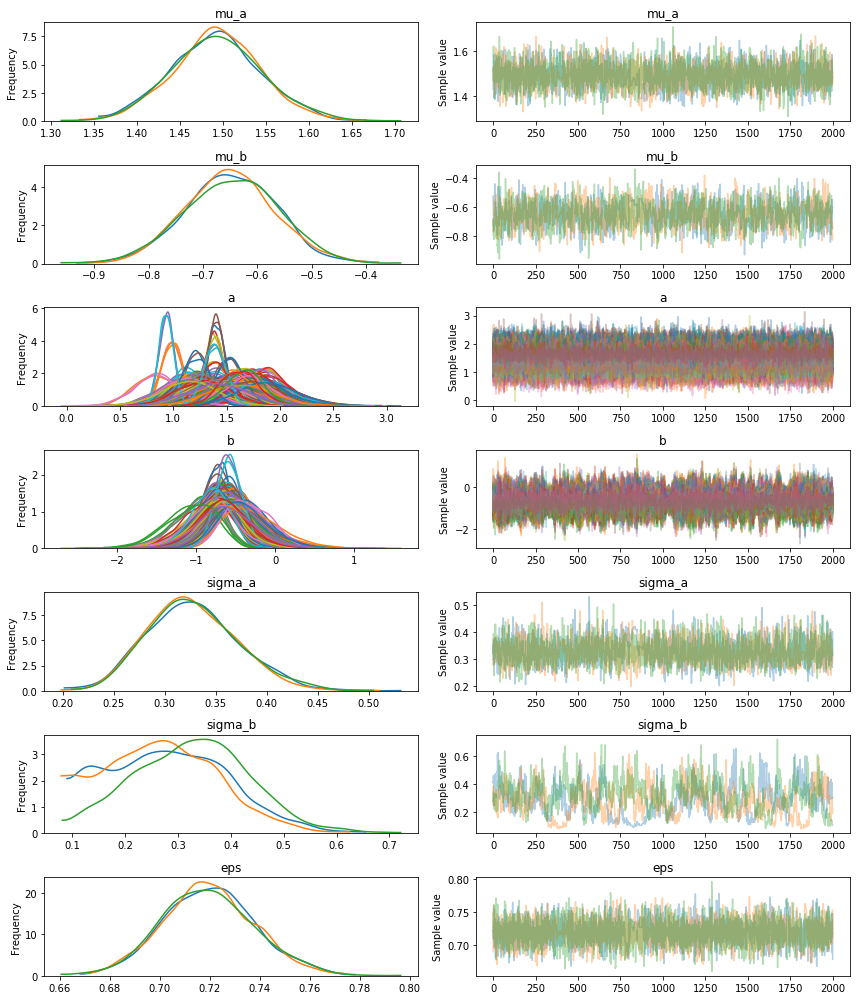

In [8]:
pm.traceplot(hierarchical_trace);

In [10]:
import pymc3 as pm
import theano.tensor as tt

def make_pymc3_sbm(Gs, k, truth, weighted=False, directed=False, selfloops=False):
    #super().__init__(name, model=None)
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    model = pm.Model()
    with model:
        #pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = truth #pm.Categorical('z', p=pi, shape=(n,))
        if weighted:
            eta = pm.Gamma('eta', alpha=.001, beta=.001, shape=(k, k))
        else:
            eta = pm.Beta('eta', alpha=1, beta=1, shape=(k, k))
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))]
        if not selfloops:
            tt.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p =  eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices]
        if weighted:
            W = pm.Poisson('W', mu=p, shape=A_obs[0].shape, observed=A_obs)
        else:
            W = pm.Bernoulli('W', p=p, shape=A_obs[0].shape, observed=A_obs)
    return model

/home/jovyan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


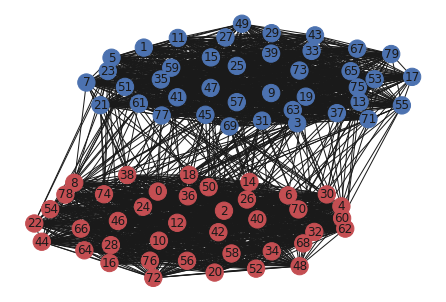

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# let's generate some data
# there are 2 communities (even and odd nodes)
# intra community edge probability is 0.8
# inter community edge probability is 0.1
Gs = []
p = 1
q = .1
t = 1
n = 80
for i in range(t):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i + 1, n):
            theta = p if (i % 2 == j % 2) else q
            if np.random.random() < theta:
                G.add_edge(i, j)
    Gs.append(G)
    
# show first 5 graphs
pos = nx.spring_layout(Gs[0])
colors = np.array(['r', 'b'])
ground_truth = np.array([i % 2 for i in range(n)])
for i in range(t):
    G = Gs[i]
    nx.draw(G, node_color=colors[ground_truth], with_labels=True, pos=pos)
    plt.show()
    plt.close()

In [9]:
#nx.to_numpy_array(Gs[0])
ground_truth

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [40]:
truth = ground_truth
model1 = make_pymc3_sbm(Gs, 2, truth)
with model1 as model_1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace_1 = pm.sample(500, tune = 500)

/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:07<00:00, 410.39draws/s]


In [41]:
truth = ground_truth
model2 = make_pymc3_sbm(Gs, 3, truth, )
with model2 as model_2:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace_2 = pm.sample(500, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:18<00:00, 160.86draws/s]


In [20]:
pm.summary(trace_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta__0_0,0.949816,0.007584,0.000156,0.935629,0.965237,2170.975045,0.999318
eta__0_1,0.119362,0.011286,0.000254,0.098965,0.142242,2219.557962,0.999759
eta__1_0,0.094251,0.010429,0.000251,0.073731,0.114351,2073.856668,0.999997
eta__1_1,0.949751,0.007936,0.000172,0.934374,0.965180,2216.290183,0.999322


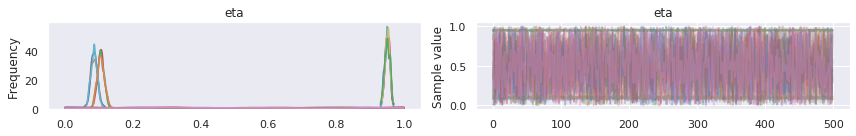

In [79]:
pm.traceplot(trace2);

/home/jovyan/.local/lib/python3.6/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/jovyan/.local/lib/python3.6/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


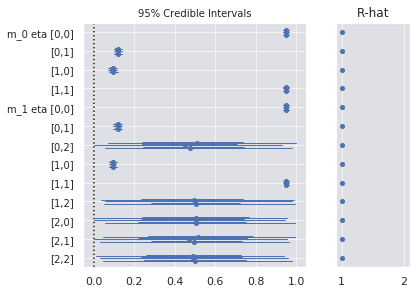

In [42]:
traces = [trace_1, trace_2]
pm.forestplot(traces);

In [43]:
models = [model_1, model_2]
model_1.name = 'k=2'
model_2.name = 'k=3'
comp = pm.compare({model_1: trace_1, model_2: trace_2}, method='BB-pseudo-BMA')
comp

/home/jovyan/.local/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
k=3,1728.45,4.06,0,0.51,72.48,0,0
k=2,1728.57,4.13,0.12,0.49,72.57,0.13,0


In [89]:
pooled_waic = pm.waic(trace_1, model_1)
pooled_waic.WAIC

/home/jovyan/.local/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


1659.4547215422385

In [45]:
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, models,
                        weights=comp.weight.sort_index(ascending=True),
                        progressbar=False)

/home/jovyan/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
